# Introduction to Bayesian active learning with GPs in 1 dimension

* This notebook provides simple code examples leveraging a light-weight GP implementation by [scikit-learn](https://scikit-learn.org/stable) to illustrate the workings of Bayesian active learning (BAL)in combination with regression in 1d. BAL is a technique from the reinforcement learning literature to automatically place observations in regions of the state space where they improve most on the quality of the approximator.

* It is supplementary material to the paper "Machine Learning for [Dynamic Incentive Problems" by P. Renner, S. Scheidegger (2018)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3282487), Section 4.3.
* BAL tackles this so-called exploration-exploitation dilemma—that is to say, the use of as few observations as possible to represent the a priori unknown polices as well as possible-by inducing observations to the training set such that only the relevant part of the state space will be explored. Hence, BAL can be seen as a strategy for optimal data selection to make learning more efficient. In our case, the training data is selected according to a function that we denote as score function. 

* In loose terms, Bayesian active learning could be considered to be the grid-free equivalent of an adaptive sparse grid algorithm. In the latter global solution method, the adaptivity of the grid now ensures that grid points are placed close to the nonlinearities while the grid remains coarse where policy functions are smoother.

* The notebook first introduces first all building blocks to BAL, and then runs the tests at the very end.

* There are 4 analytic test functions in one dimension:
    - a sin function
    - the relu function: (1 kink)
    - an absolute function of a sine: |sin((pi/2)*x)|
    - and clipped absolute value function (4 kinks)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.linalg import cholesky, cho_solve, solve_triangular
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C

Here, we define a function that returns the posterior predictive mean and variance of x* conditional on the training set, one of the key ingrediences for BAL.

In [2]:
def compute_moments(x, gp):
    """Calculate posterior predictive mean and variance of x* conditional on the training set."""

    e_gp, K = gp.predict(x, return_cov=True)
    k_xnew = K[-1, -1]
    k_xnew_xtrain = K[-1, :-1]
    K_xtrain = K[:-1, :-1]
    var_gp = k_xnew - np.dot(np.dot(k_xnew_xtrain, np.linalg.inv(K_xtrain)), k_xnew_xtrain.T)

    return e_gp[-1], var_gp

Next, we define the BAL utility, also known as "score function". This function is used to assessed where additional points should be optimally placed to the training set. 

In [3]:
def bal_utility(e_gp, var_gp, rho=1.0, beta=10):
    """Calculate utility for Bayesian active learning."""
    utility = rho * e_gp + (beta / 2.0) * np.log(var_gp)
    
    return utility

Now, we specify the four test functions:

In [4]:
# Test 
def f_sin(x):
    """Calculate f(x) = x^sin(x)."""
    return x ** np.sin(x)

def f_relu(x):
    """Calculate f(x) = relu(x)."""
    x = np.copy(x)
    x[x<0] = 0
    return x

pi = 3.14159
def f_abs_sin(x):
    """Calculate f(x) = |sin((pi/2)*x)|."""
    return np.abs(np.sin(pi/2.0*x))

def f_abs_clip(x):
    """Calculate f(x) = clip(x)"""
    return np.clip(np.abs(np.copy(x)), 0.1, 0.3)

Here, a plotting routine to vizualize the predictive mean (i.e., the interpolated function) and the 95% confidenence band: 

In [5]:
def plot_fn(X, y, gp, f, fn, xmin=0, xmax=5, ymin=0, ymax=2.3):
    """Plot the function, the prediction and the 95% confidence interval based on the MSE."""
    x = np.atleast_2d(np.linspace(xmin, xmax, 1000)).T
    y_pred, sigma = gp.predict(x, return_std=True)

    plt.figure()
    plt.plot(x, f(x), 'r:', label=r'$f(x) $') #label=r'$f(x) = x^{\sin(x)}$')
    plt.plot(X, y, 'r.', markersize=10, label=u'Observations')
    plt.plot(x, y_pred, 'b-', label=u'Prediction')
    plt.fill(np.concatenate([x, x[::-1]]),
             np.concatenate([y_pred - 1.9600 * sigma,
                            (y_pred + 1.9600 * sigma)[::-1]]),
             alpha=.5, fc='b', ec='None', label='95% CI')
    plt.xlabel('$x$')
#    plt.ylabel(r'$f(x) = x^{\sin(x)}$')
    plt.ylabel(r'f(x)=|sin((pi/2)*x)|')   
    plt.ylim(ymin, ymax)
    plt.xlim(xmin, xmax)
    plt.legend(loc='upper right')
    # plt.savefig('./output/bal_test/' + fn)
    plt.show()
    plt.close()

* Next, we provide a simple implementation of BAL. The latter is not tuned, but merely a showcase the inner workings of BAL.

* Note that in this 1-d example, we generate the candidate points only once for simplicity. However, note that in the general case, these points could be drawn from scratch e.g., by sampling, after every update of the GP.

* The subsequent functions provide error measures to assess how the approximation error decreases by applying BAL.

In [6]:
def bayesian_active_learning_1d(n_iters, f, xmin, xmax, ymin, ymax):
    
    
    ## there are various ways to come up with an initial training set.    
    # 1. manually pick points for the initial training set
    # X = np.array([[0.1], [0.5], [4.3], [4.5], [4.9]])
    ## 2. alternative: randomly create an initual training set
    seed = 666
    np.random.seed(seed)    
    n = 1 # number of samples
    d = 1  # number of dimensions
    X = np.random.uniform(low=xmin, high=xmax,size=(int(n),d))
    # 3. uniformly distribute points
    # X0 = np.linspace(xmin,xmax,5) 
    # X=X0.reshape(-1,1)
    
    # get training target 
    y = f(X).ravel()

    # for simplicity, generate an ex-ante set of candidate points 
    n = 1000 # number of samples
    d = 1   # number of dimensions    
    x_candidates = np.random.uniform(low=xmin, high=xmax,size=(int(n),d))
    x_candidates = x_candidates[1:]

    # Choose a Covariance kernel
    # kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
    # kernel = RBF(10, (1e-2, 1e2))
    kernel = 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=1.5)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-6)
    gp.fit(X, y)

    # plot initial GP
    plot_fn(X, y, gp, f, 'x0.png', xmin, xmax, ymin, ymax)
    err_list = {}
    
    
    assert n > n_iters, f"number greater than 0 expected, got: {n}"
        
    # score the candidate points via the BAL score function.
    for j in range(n_iters):
        
        # compute error between true and interpolated function
        y_preds = gp.predict(x_candidates.reshape(-1, 1))
        errs = np.abs(f(x_candidates.reshape(-1, 1)).ravel() - y_preds)
        err = np.mean(np.abs(f(x_candidates.reshape(-1, 1)).ravel() - y_preds))
        err_list[j] = err
        print('Mean approximation error {}:' .format(err_list[j]))
        
        # perform BAL
        U_bal = np.zeros_like(x_candidates)

        for i, _x in enumerate(x_candidates):
            x_tmp = np.concatenate([X, np.atleast_2d(_x)])
            e_gp, var_gp = compute_moments(x_tmp, gp)
            U_bal[i] = bal_utility(e_gp, var_gp)

        i_new = np.nanargmax(U_bal)
        x_new = x_candidates[i_new]
        x_candidates = np.delete(x_candidates, i_new, 0)
        
        print('Augmenting {}th candidate {} with U_BAL = {}'.format(i_new, x_new, U_bal[i_new]))

        X = np.concatenate([X, np.atleast_2d(x_new)])
        y = f(X).ravel()

        # Update data
        gp.X_train_ = np.copy(X)
        gp.y_train_ = np.copy(f(X).ravel())
        K = gp.kernel_(gp.X_train_)
        K[np.diag_indices_from(K)] += gp.alpha
        gp.L_ = cholesky(K, lower=True)
        gp.alpha_ = cho_solve((gp.L_, True), gp.y_train_)
        L_inv = solve_triangular(gp.L_.T, np.eye(gp.L_.shape[0]))
        gp._K_inv = L_inv.dot(L_inv.T)

        plot_fn(X, y, gp, f, 'x{}.png'.format(j + 1), xmin, xmax, ymin, ymax)
    return X, err_list

* Next, we train a GP with samples that ar uniform distributed. 

* The rate of convergence is substantially slower than in the case of BAL.

In [7]:
def GP_uniform_1d(n_iters, f, xmin, xmax, ymin, ymax):
      
    ## there are various ways to come up with an initial training set.    
    # 1. manually pick points for the initial training set
    #X1 = np.array([[0.1], [0.5], [4.3], [4.5], [4.9]])
    #print(X1)
    
    # for simplicity, generate an ex-ante set of n candidate points 
    seed = 666
    np.random.seed(seed)       
    n = 1000 # number of samples
    d = 1    # number of dimensions    
    x_candidates = np.random.uniform(low=xmin, high=xmax,size=(int(n),d))
    x_candidates = x_candidates[1:]    
    err_list = {}

    for j in range(0, n_iters):
        
        # 1. generate uniformly distributed random samples
        seed = 666
        np.random.seed(seed)           
        n = j+1  # number of samples
        d = 1  # number of dimensions
        X1 = np.random.uniform(low=xmin, high=xmax,size=(int(n),d))        
        # 2. generate a equally-spaced grid of j points
        #X = np.linspace(xmin,xmax,j)
        #print(X)
        #X1=X.reshape(-1,1)
        
        # training data
        y = f(X1).ravel()
        
        # Choose a Covariance kernel
        # kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
        # kernel = RBF(10, (1e-2, 1e2))
        kernel = 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=1.5)
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-6)    
        gp.fit(X1, y)        
    
        # compute error between true and interpolated function
        y_preds = gp.predict(x_candidates.reshape(-1, 1))
        errs = np.abs(f(x_candidates.reshape(-1, 1)).ravel() - y_preds)
        err = np.mean(np.abs(f(x_candidates.reshape(-1, 1)).ravel() - y_preds))    
        err_list[j] = err
        print('Mean approximation error {}:' .format(err_list[j]))
        plot_fn(X1, y, gp, f, 'x{}.png'.format(j + 1), xmin, xmax, ymin, ymax)
    
    return X, err_list


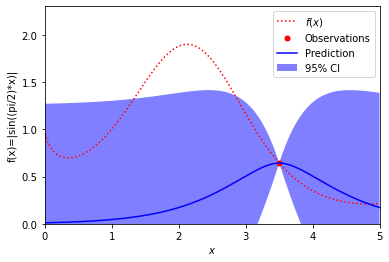

Mean approximation error 0.7686601963563539:
Augmenting 812th candidate [0.93738108] with U_BAL = [-4.40172306]


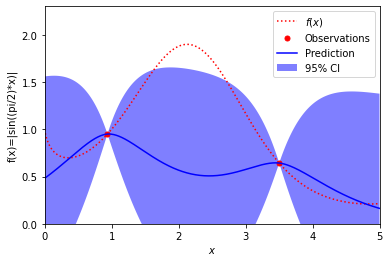

Mean approximation error 0.4494853553282808:
Augmenting 403th candidate [4.996565] with U_BAL = [-4.63631948]


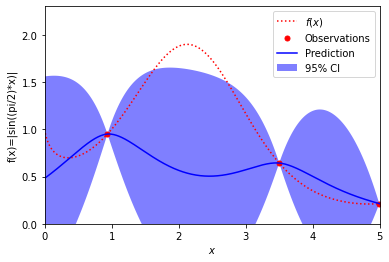

Mean approximation error 0.4566367000617569:
Augmenting 303th candidate [2.19844078] with U_BAL = [-5.21695854]


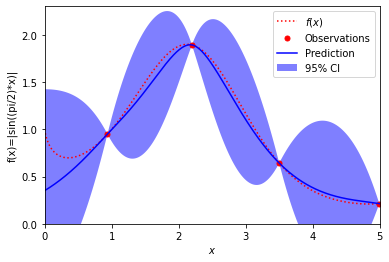

Mean approximation error 0.06272646136828097:
Augmenting 125th candidate [0.00560546] with U_BAL = [-5.69902981]


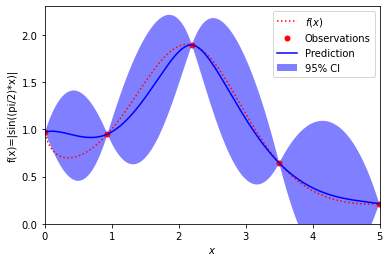

Mean approximation error 0.07419458545030165:
Augmenting 294th candidate [4.2459956] with U_BAL = [-9.04834803]


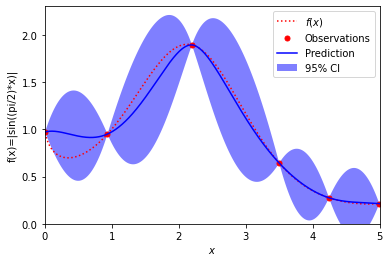

Mean approximation error 0.06765910455925976:
Augmenting 372th candidate [2.81509872] with U_BAL = [-9.54453221]


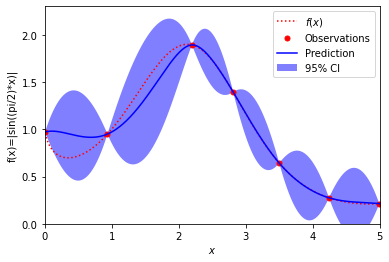

Mean approximation error 0.06358399203775608:
Augmenting 294th candidate [1.58271608] with U_BAL = [-9.95107077]


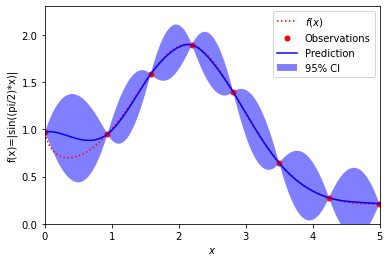

Mean approximation error 0.03432739074061184:
Augmenting 300th candidate [0.45834841] with U_BAL = [-13.5346198]


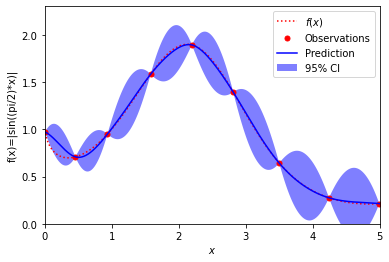

Mean approximation error 0.01628107960891516:
Augmenting 101th candidate [4.62651633] with U_BAL = [-16.66388375]


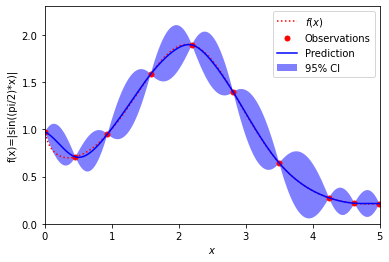

Mean approximation error 0.014957011854414805:
Augmenting 54th candidate [3.85693463] with U_BAL = [-17.33503627]


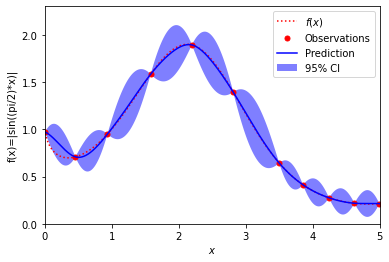

Mean approximation error 0.01497461993360109:
Augmenting 811th candidate [3.14152939] with U_BAL = [-17.81680971]


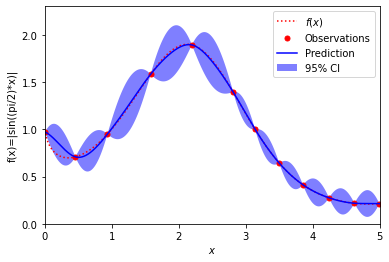

Mean approximation error 0.7684789899838659:


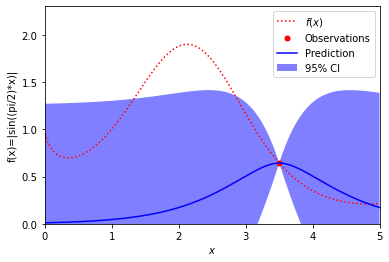

Mean approximation error 0.7075113846427109:


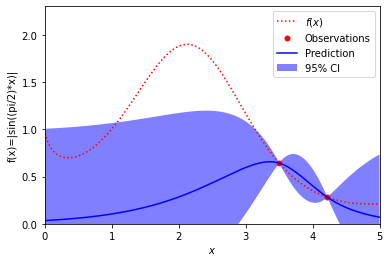

Mean approximation error 0.43239314766549275:


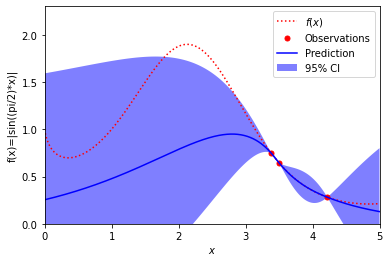

Mean approximation error 0.2239887941580993:


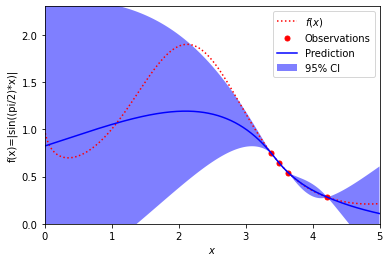

Mean approximation error 0.22448081678423076:


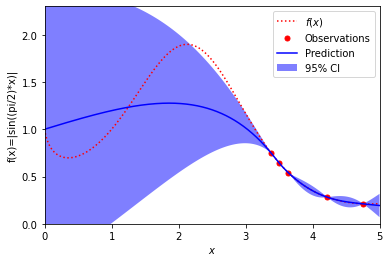

Mean approximation error 0.22057073068868374:


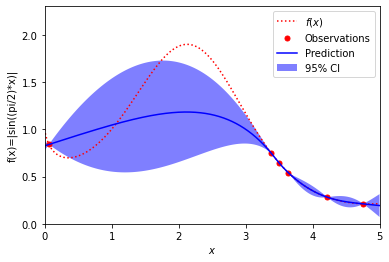

Mean approximation error 0.15635741529715816:


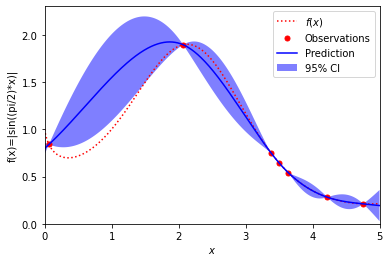

Mean approximation error 0.016852452477992195:


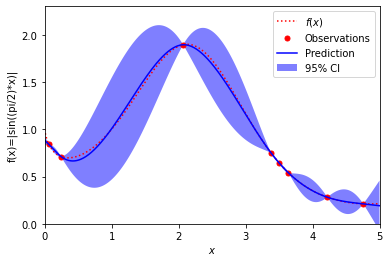

Mean approximation error 0.028146352474334294:


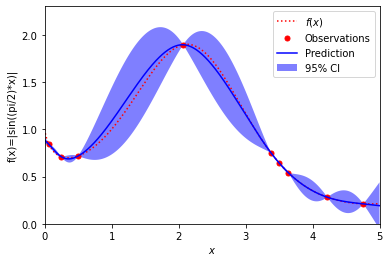

Mean approximation error 0.019436701376554687:


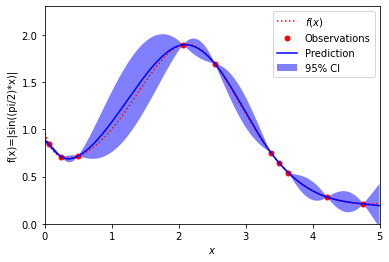

BAL - sin error {0: 0.7686601963563539, 1: 0.4494853553282808, 2: 0.4566367000617569, 3: 0.06272646136828097, 4: 0.07419458545030165, 5: 0.06765910455925976, 6: 0.06358399203775608, 7: 0.03432739074061184, 8: 0.01628107960891516, 9: 0.014957011854414805, 10: 0.01497461993360109}
uniform - sin error {0: 0.7684789899838659, 1: 0.7075113846427109, 2: 0.43239314766549275, 3: 0.2239887941580993, 4: 0.22448081678423076, 5: 0.22057073068868374, 6: 0.15635741529715816, 7: 0.016852452477992195, 8: 0.028146352474334294, 9: 0.019436701376554687}


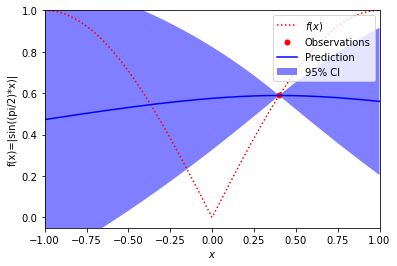

Mean approximation error 0.2943857662819998:
Augmenting 125th candidate [-0.99775782] with U_BAL = [-9.99476519]


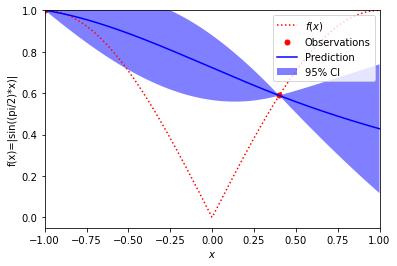

Mean approximation error 0.2980668901372821:
Augmenting 402th candidate [0.998626] with U_BAL = [-18.00295783]


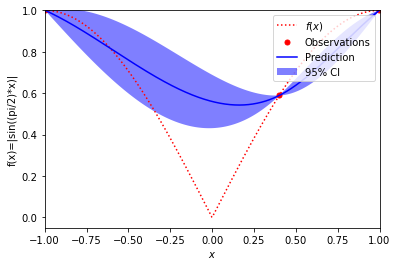

Mean approximation error 0.1485520808885362:
Augmenting 253th candidate [-0.35224189] with U_BAL = [-23.71613877]


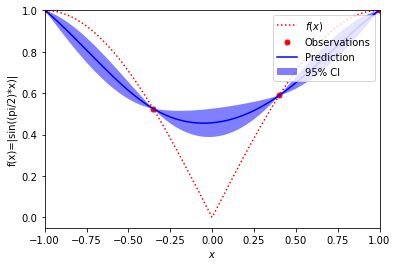

Mean approximation error 0.12239178113447081:
Augmenting 721th candidate [0.02256396] with U_BAL = [-33.09639386]


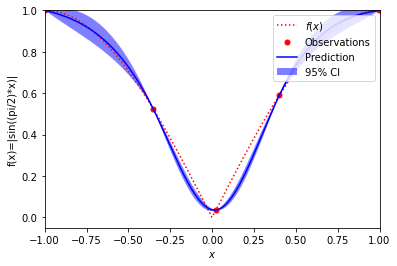

Mean approximation error 0.024210672681264495:
Augmenting 242th candidate [-0.70339978] with U_BAL = [-34.26929689]


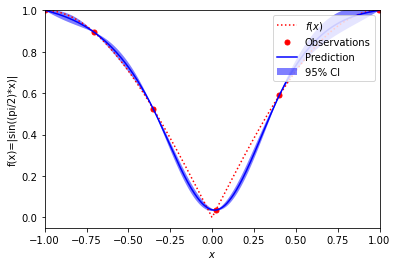

Mean approximation error 0.02419684843264947:
Augmenting 214th candidate [0.7224965] with U_BAL = [-35.28041323]


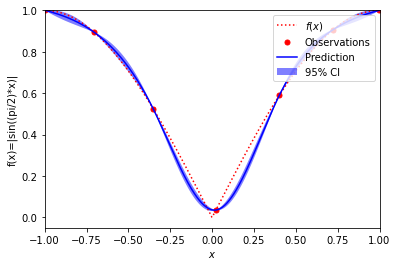

Mean approximation error 0.023053702711771724:
Augmenting 617th candidate [0.21700149] with U_BAL = [-43.5442715]


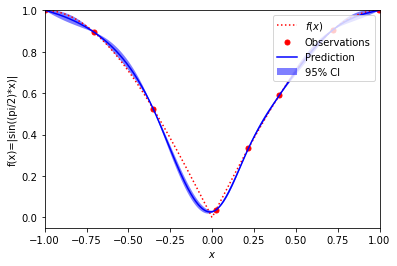

Mean approximation error 0.017357897289494505:
Augmenting 241th candidate [-0.52872986] with U_BAL = [-44.01585102]


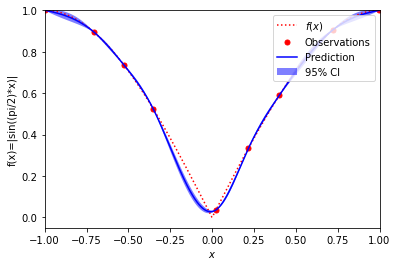

Mean approximation error 0.013237760078527842:
Augmenting 32th candidate [-0.16657599] with U_BAL = [-44.73155863]


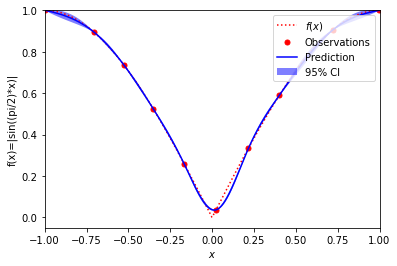

Mean approximation error 0.006276315128152857:
Augmenting 464th candidate [-0.86320227] with U_BAL = [-45.65140292]


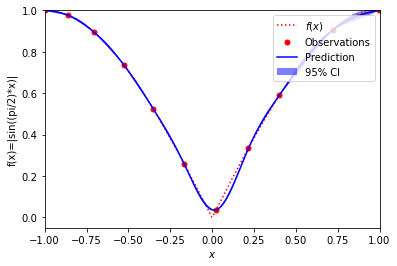

Mean approximation error 0.527995533434202:


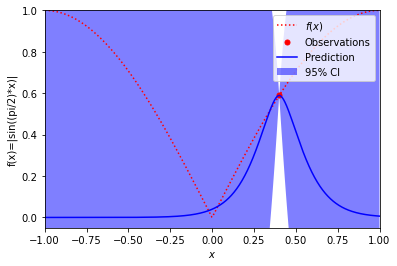

Mean approximation error 0.3009630776045311:


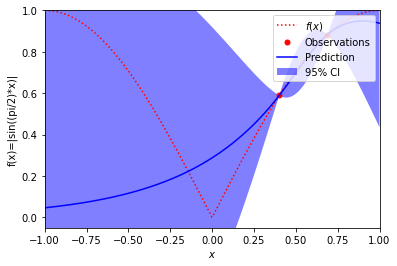

Mean approximation error 0.35517826668047564:


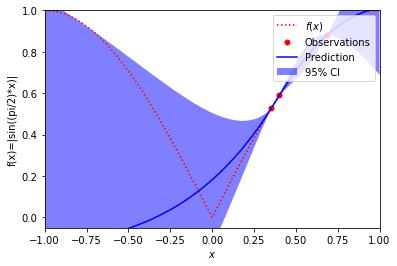

Mean approximation error 0.418590564402898:


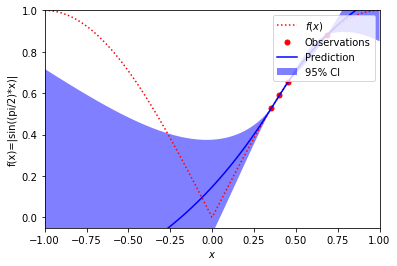

Mean approximation error 0.40787728505205295:


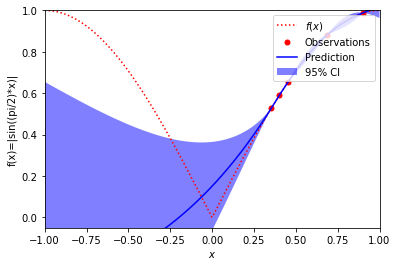

Mean approximation error 0.0677743455627831:


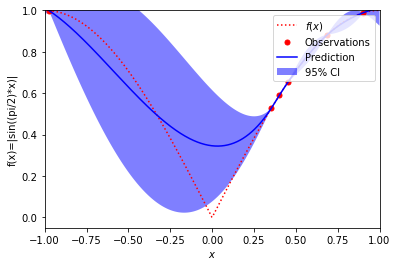

Mean approximation error 0.08106340831255741:


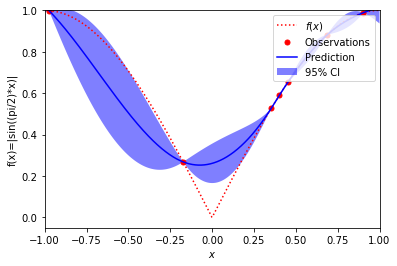

Mean approximation error 0.04963928536400311:


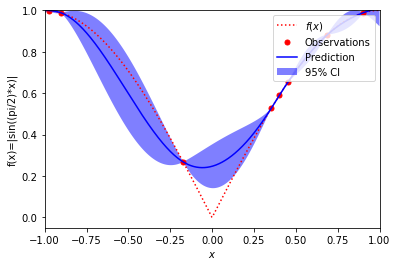

Mean approximation error 0.041917184871033956:


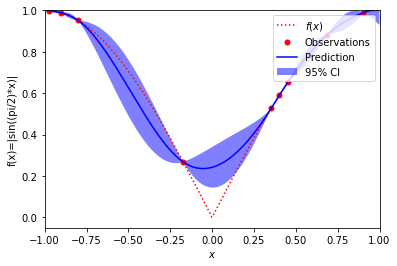

Mean approximation error 0.01112126311365817:


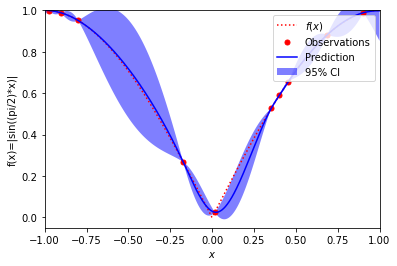

BAL - relu error {0: 0.2943857662819998, 1: 0.2980668901372821, 2: 0.1485520808885362, 3: 0.12239178113447081, 4: 0.024210672681264495, 5: 0.02419684843264947, 6: 0.023053702711771724, 7: 0.017357897289494505, 8: 0.013237760078527842, 9: 0.006276315128152857}
uniform - relu error {0: 0.527995533434202, 1: 0.3009630776045311, 2: 0.35517826668047564, 3: 0.418590564402898, 4: 0.40787728505205295, 5: 0.0677743455627831, 6: 0.08106340831255741, 7: 0.04963928536400311, 8: 0.041917184871033956, 9: 0.01112126311365817}


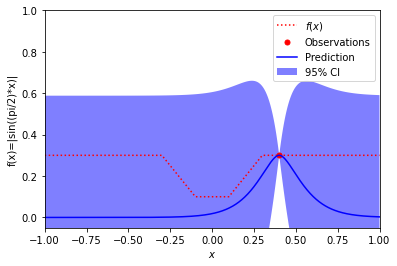

Mean approximation error 0.2067498055883457:
Augmenting 793th candidate [-0.0765325] with U_BAL = [-12.03528571]


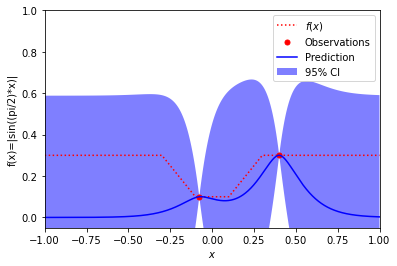

Mean approximation error 0.19065391646565658:
Augmenting 257th candidate [0.87681188] with U_BAL = [-12.03534819]


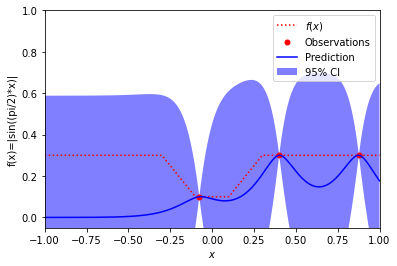

Mean approximation error 0.15154498923507073:
Augmenting 871th candidate [-0.6754809] with U_BAL = [-12.03934591]


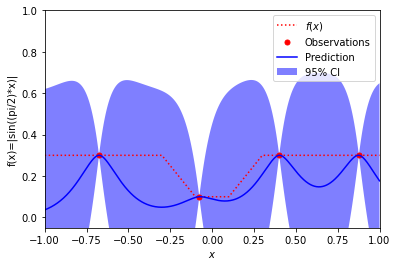

Mean approximation error 0.10128227744149187:
Augmenting 125th candidate [-0.99775782] with U_BAL = [-12.08041616]


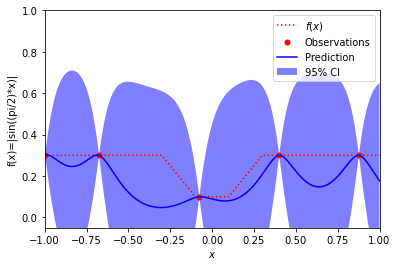

Mean approximation error 0.08255032503617339:
Augmenting 115th candidate [-0.3820196] with U_BAL = [-12.21711887]


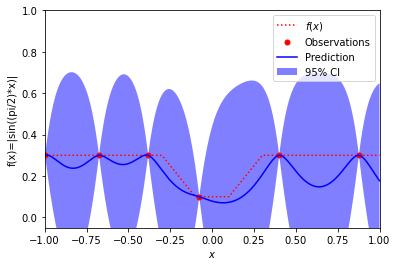

Mean approximation error 0.04860815134705597:
Augmenting 428th candidate [0.6388862] with U_BAL = [-12.56313413]


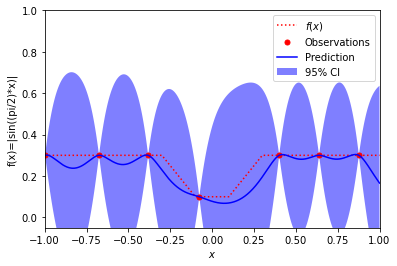

Mean approximation error 0.03351949048957367:
Augmenting 634th candidate [0.16533017] with U_BAL = [-12.62541979]


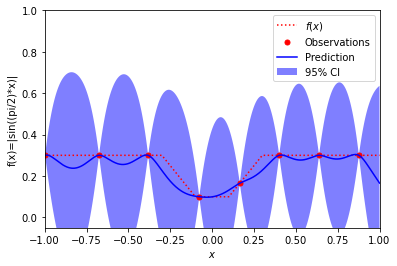

Mean approximation error 0.02757791250412726:
Augmenting 400th candidate [0.998626] with U_BAL = [-14.17314951]


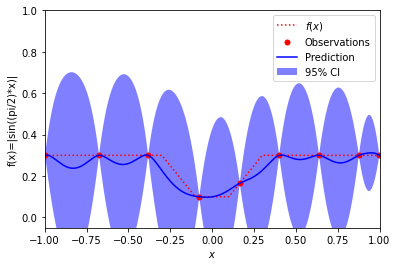

Mean approximation error 0.026087009719520663:
Augmenting 223th candidate [-0.83708151] with U_BAL = [-14.18098225]


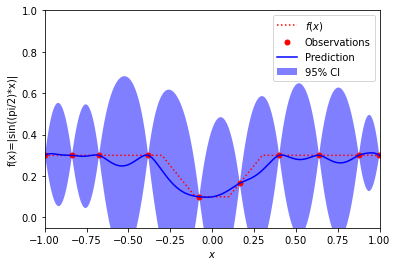

Mean approximation error 0.021614123147563405:
Augmenting 707th candidate [-0.23064128] with U_BAL = [-14.62148139]


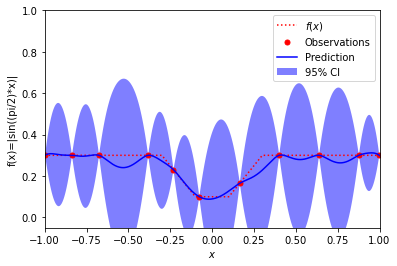

Mean approximation error 0.016326699876623146:
Augmenting 241th candidate [-0.52872986] with U_BAL = [-14.93779517]


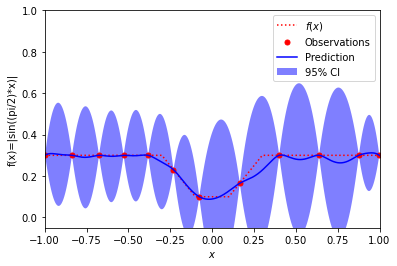

Mean approximation error 0.012404516739705964:
Augmenting 517th candidate [0.51951041] with U_BAL = [-16.43773834]


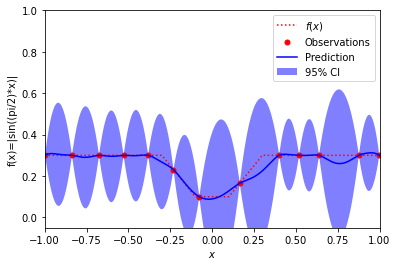

Mean approximation error 0.01221663794734738:
Augmenting 566th candidate [0.04599509] with U_BAL = [-16.5553844]


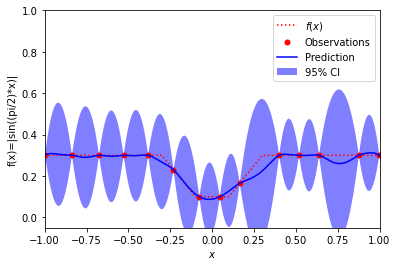

Mean approximation error 0.012230090609728983:
Augmenting 198th candidate [0.75741867] with U_BAL = [-16.73906348]


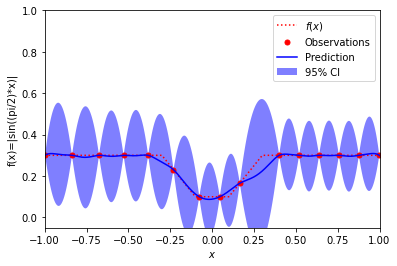

Mean approximation error 0.00957103064310088:
Augmenting 468th candidate [0.28158971] with U_BAL = [-16.89494847]


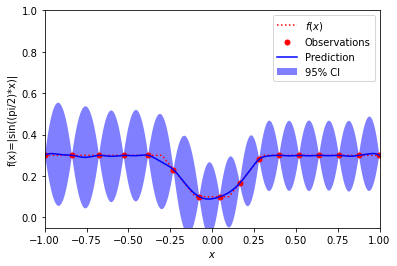

Mean approximation error 0.004453284704500802:
Augmenting 113th candidate [-0.918209] with U_BAL = [-20.32305641]


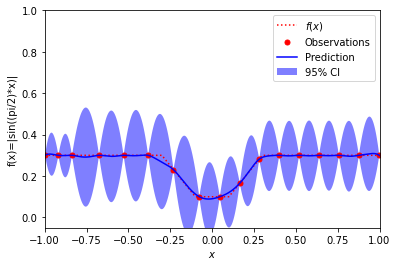

Mean approximation error 0.004215313253659126:
Augmenting 690th candidate [-0.75493852] with U_BAL = [-20.73905957]


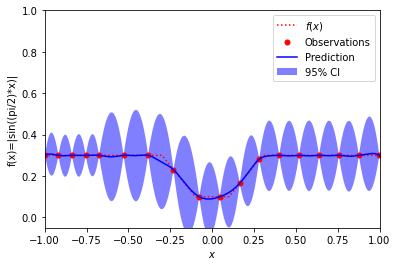

Mean approximation error 0.003994322161726951:
Augmenting 882th candidate [-0.15511028] with U_BAL = [-21.19831968]


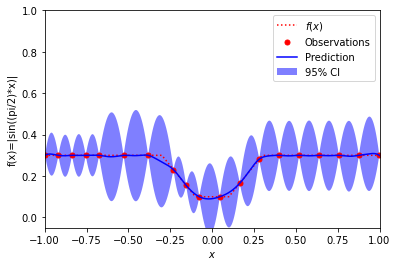

Mean approximation error 0.0037677723297943806:
Augmenting 543th candidate [-0.30787988] with U_BAL = [-21.52998253]


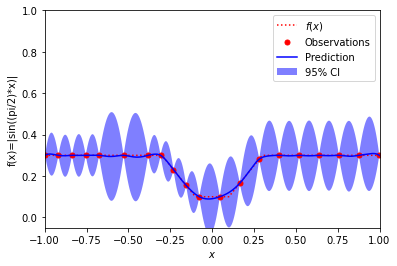

Mean approximation error 0.0031495270428816783:
Augmenting 467th candidate [-0.60126465] with U_BAL = [-21.84799948]


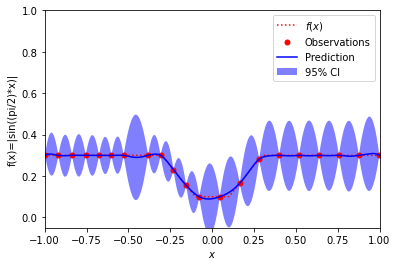

Mean approximation error 0.20562662218994643:


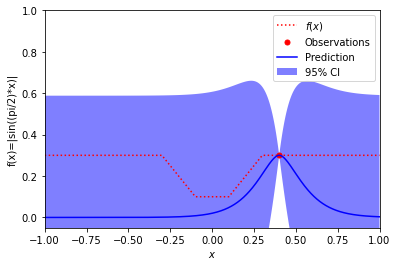

Mean approximation error 0.04100407700672688:


/home/simon/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


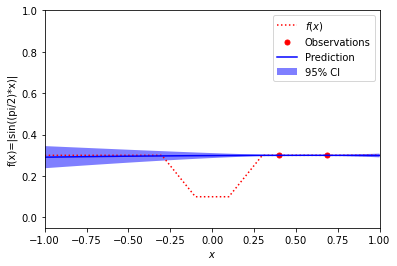

Mean approximation error 0.04095396950559361:


/home/simon/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


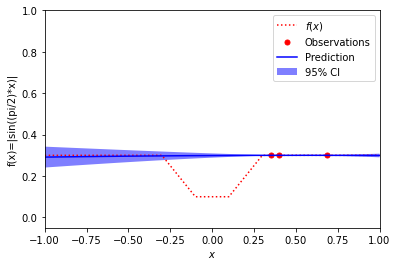

Mean approximation error 0.040920608589358844:


/home/simon/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


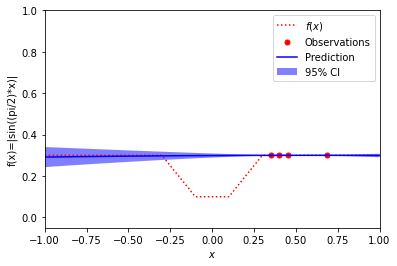

Mean approximation error 0.040889293411177315:


/home/simon/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


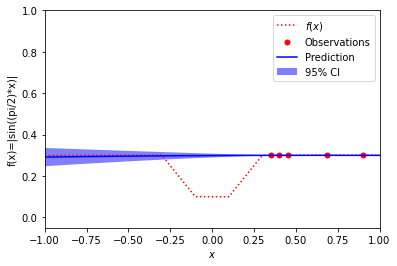

Mean approximation error 0.039620995841138144:


/home/simon/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


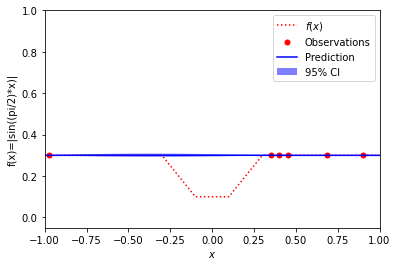

Mean approximation error 0.05008508231701689:


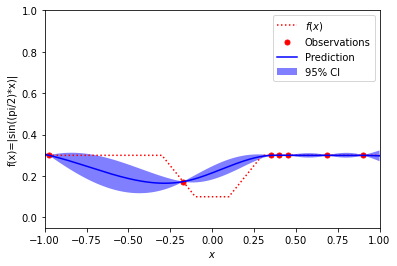

Mean approximation error 0.04140877766734646:


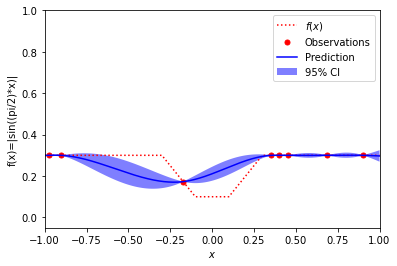

Mean approximation error 0.0366105030199725:


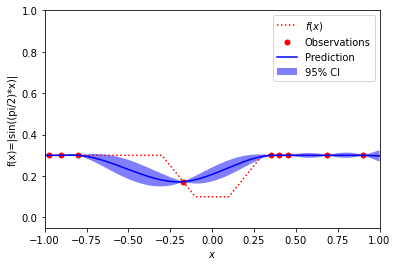

Mean approximation error 0.011753184090694811:


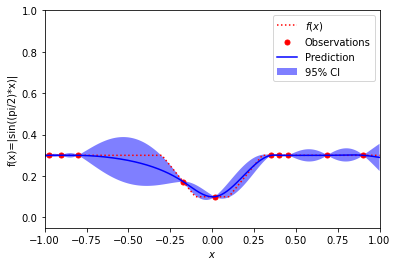

Mean approximation error 0.009673561331618726:


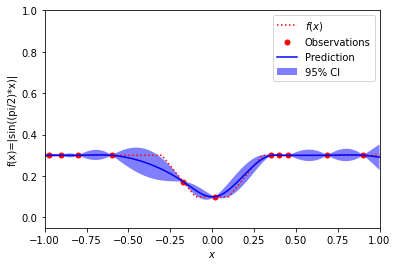

Mean approximation error 0.009634106819697771:


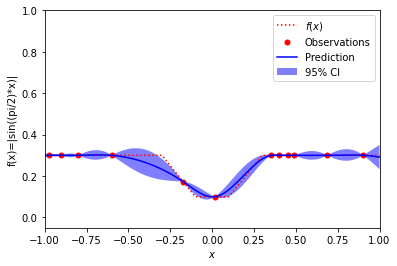

Mean approximation error 0.00907884141733088:


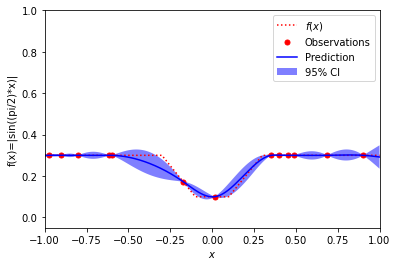

Mean approximation error 0.00908041724339656:


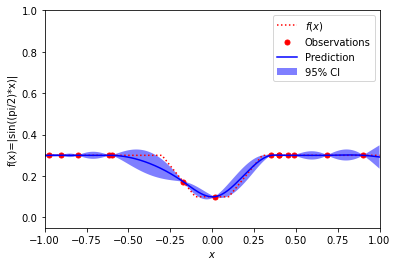

Mean approximation error 0.0061743294928270215:


/home/simon/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


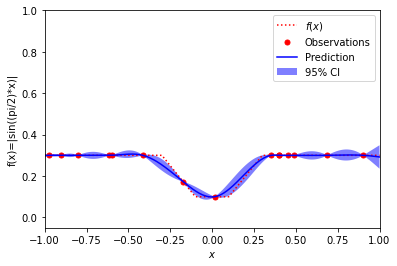

Mean approximation error 0.006142533425653302:


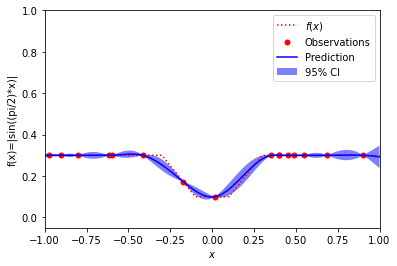

Mean approximation error 0.006128851974020805:


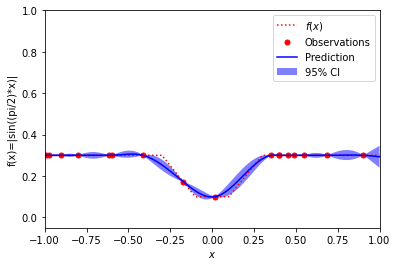

Mean approximation error 0.006115966216642861:


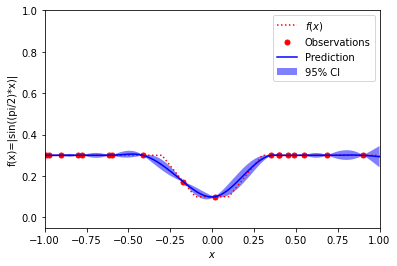

Mean approximation error 0.006115392170541807:


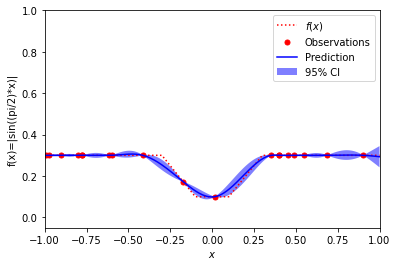

Mean approximation error 0.005638330980869706:


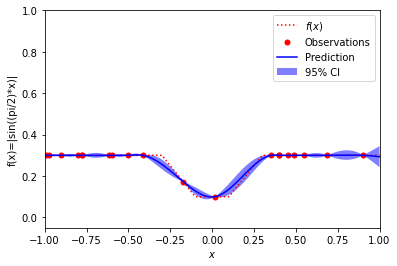

BAL - clips error {0: 0.2067498055883457, 1: 0.19065391646565658, 2: 0.15154498923507073, 3: 0.10128227744149187, 4: 0.08255032503617339, 5: 0.04860815134705597, 6: 0.03351949048957367, 7: 0.02757791250412726, 8: 0.026087009719520663, 9: 0.021614123147563405, 10: 0.016326699876623146, 11: 0.012404516739705964, 12: 0.01221663794734738, 13: 0.012230090609728983, 14: 0.00957103064310088, 15: 0.004453284704500802, 16: 0.004215313253659126, 17: 0.003994322161726951, 18: 0.0037677723297943806, 19: 0.0031495270428816783}
uniform - clips error {0: 0.20562662218994643, 1: 0.04100407700672688, 2: 0.04095396950559361, 3: 0.040920608589358844, 4: 0.040889293411177315, 5: 0.039620995841138144, 6: 0.05008508231701689, 7: 0.04140877766734646, 8: 0.0366105030199725, 9: 0.011753184090694811, 10: 0.009673561331618726, 11: 0.009634106819697771, 12: 0.00907884141733088, 13: 0.00908041724339656, 14: 0.0061743294928270215, 15: 0.006142533425653302, 16: 0.006128851974020805, 17: 0.006115966216642861, 18: 0.0

In [8]:
if __name__ == "__main__":
    X , L2_BAL_sin = bayesian_active_learning_1d(11, f_sin, xmin=0, xmax=5, ymin=0.0, ymax=2.3)
    X , L2_uniform_sin = GP_uniform_1d(10, f_sin, xmin=0, xmax=5, ymin=0.0, ymax=2.3)
    print("BAL - sin error", L2_BAL_sin)
    print("uniform - sin error", L2_uniform_sin)

    X , L2_BAL_relu = bayesian_active_learning_1d(10, f_abs_sin, xmin=-1, xmax=1, ymin=-0.05, ymax=1.0)
    X , L2_uniform_relu = GP_uniform_1d(10, f_abs_sin, xmin=-1, xmax=1, ymin=-0.05, ymax=1.0)    
    print("BAL - relu error", L2_BAL_relu)
    print("uniform - relu error", L2_uniform_relu)
    
    X , L2_BAL_clips = bayesian_active_learning_1d(20, f_abs_clip, xmin=-1, xmax=1, ymin=-0.05, ymax=1.0)
    X , L2_uniform_clips = GP_uniform_1d(20, f_abs_clip, xmin=-1, xmax=1, ymin=-0.05, ymax=1.0)
    print("BAL - clips error", L2_BAL_clips)
    print("uniform - clips error", L2_uniform_clips)    